# Revenue Trend Forecasting

## Objective

The primary goal of this project was to build a state-of-the-art time series forecasting system that accurately predicts key business metrics, enabling Olist to anticipate future trends and support critical business decisions. This mission includes:
1. **Accurately forecasting order volumes**, which optimizes inventory and resource management, minimizing stockouts and overstocking.
2. **Forecasting revenue trends**, which provides a clear financial roadmap and supports strategic planning and long-term growth.

This notebook focuses on **forecasting revenue trends**. To achieve this, I preprocess the dataset to ensure data quality and readiness for effective model development and evaluation. The insights generated serve as a foundation for actionable recommendations to drive business success.

## Dataset Description

It was powered by Olist's real transaction data, comprising over 100,000 orders across Brazil's diverse regions, collected from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data).

**olist_orders_dataset.csv:**

| No. | Column Name | Description |
|---|-------------|-------------|
| 1 | order_id | Unique identifier for each order. |
| 2 | customer_id | Unique identifier for the customer who placed the order. |
| 3 | order_status | Current status of the order (e.g., `delivered`, `shipped`, `canceled`, etc.). |
| 4 | order_purchase_timestamp | Timestamp when the order was placed by the customer. |
| 5 | order_approved_at | Timestamp when payment for the order was approved. |
| 6 | order_delivered_carrier_date | Timestamp when the order was handed to the logistics partner for delivery. |
| 7 | order_delivered_customer_date | Timestamp when the order was delivered to the customer. |
| 8 | order_estimated_delivery_date | Estimated delivery date provided at the time of purchase. |

**olist_order_payments_dataset.csv:**

| No. | Column Name | Description |
|---|-------------|-------------|
| 1 | order_id | Unique identifier for the order. |
| 2 | payment_sequential | Number of payment attempts (e.g., `1` for a single payment, `2` if split into two transactions). |
| 3 | payment_type | Method of payment (e.g., `credit_card`, `boleto`, `voucher`, `debit_card`). |
| 4 | payment_installments | Number of installments the payment was divided into (e.g., `1` for lump sum). |
| 5 | payment_value | Total value of the payment for the order installment. |

# Importing Library

In [1]:
import pytz
import joblib
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from calendar import month_name
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

# Loading Data and Exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load all the datasets
base_path = '/content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/'

orders = pd.read_csv(base_path + 'dataset/olist_orders_dataset.csv')
order_payments = pd.read_csv(base_path + 'dataset/olist_order_payments_dataset.csv')

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [7]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [8]:
# Merge orders with payments data
payments = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
merged_orders = orders.merge(payments, on='order_id', how='inner')

In [9]:
# Filter only completed orders
valid_statuses = ['delivered']
merged_orders = merged_orders[merged_orders['order_status'].isin(valid_statuses)]

In [10]:
# Convert to datetime and extract date
merged_orders['order_purchase_timestamp'] = pd.to_datetime(merged_orders['order_purchase_timestamp'])
merged_orders['ds'] = merged_orders['order_purchase_timestamp'].dt.date

In [11]:
# Calculate daily revenue
daily_revenue = merged_orders.groupby('ds')['payment_value'].sum().reset_index()
daily_revenue.columns = ['ds', 'y']

In [12]:
# Create complete date sequence using the already converted dates
start_date = merged_orders['ds'].min()
end_date = merged_orders['ds'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date

In [13]:
# Create final DataFrame using reindex for better performance
daily_revenue = (
    daily_revenue.set_index('ds')
    .reindex(all_dates, fill_value=0)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

In [14]:
# Convert to datetime at the end
daily_revenue['ds'] = pd.to_datetime(daily_revenue['ds'])

## Remove Anomalous Dates

**Monthly anomaly**

In [15]:
# Create monthly time series
monthly_orders = (
    merged_orders.set_index('order_purchase_timestamp')
    .resample('M')
    .size()
    .reset_index(name='total_revenue')
    .rename(columns={'order_purchase_timestamp': 'ds'})
)
monthly_orders

,ds,total_revenue
0,2016-10-31,265
1,2016-11-30,0
2,2016-12-31,1
3,2017-01-31,750
4,2017-02-28,1653
5,2017-03-31,2546
6,2017-04-30,2303
7,2017-05-31,3546
8,2017-06-30,3135
9,2017-07-31,3872


Based on the above results, the daily revenue in 2016 was significantly lower compared to the monthly revenue in 2017 and 2018. This discrepancy could have negatively impacted the accuracy of the time series forecasting model and was likely caused by data errors. Therefore, I decided to drop the 2016 data to improve model performance.

In [16]:
# I only chose dates between 2017-01 and 2018-08
daily_revenue = daily_revenue[
    (daily_revenue['ds'] >= '2017-01-01') &
    (daily_revenue['ds'] <= '2018-08-31')
]

**Daily anomaly**

In [17]:
daily_revenue.head(20)

,ds,y
90,2017-01-01,0.00
91,2017-01-02,0.00
92,2017-01-03,0.00
93,2017-01-04,0.00
94,2017-01-05,707.27
95,2017-01-06,988.28
96,2017-01-07,1447.99
97,2017-01-08,507.85
98,2017-01-09,774.51
99,2017-01-10,1571.17


In [18]:
daily_revenue.tail(20)

,ds,y
676,2018-08-10,38934.43
677,2018-08-11,30511.58
678,2018-08-12,34260.37
679,2018-08-13,45431.38
680,2018-08-14,51138.46
681,2018-08-15,52083.74
682,2018-08-16,41699.15
683,2018-08-17,36948.84
684,2018-08-18,28475.76
685,2018-08-19,29989.35


From the results above, it appears that there are incomplete revenue for the dates between 2018-08-24 and 2018-08-29. This is likely due to orders not yet reaching the "delivered" status. To ensure accuracy, these dates were excluded from the analysis.

 Additionally, excluding these dates aligns the daily order data with the processing steps in another notebook.

In [19]:
# List of dates to exclude
exclude_dates = ['2018-08-24', '2018-08-25', '2018-08-26',
                 '2018-08-27', '2018-08-28', '2018-08-29']

# Convert exclude_dates to datetime format
exclude_dates = pd.to_datetime(exclude_dates)

# Exclude the dates from daily_revenue
daily_revenue = daily_revenue[~daily_revenue['ds'].isin(exclude_dates)]

In [20]:
# Create complete date range covering the data
full_date_range = pd.date_range(
    start=daily_revenue['ds'].min(),
    end=daily_revenue['ds'].max(),
    freq='D'  # 'D' for daily frequency
)

In [21]:
# Find missing dates
missing_dates = full_date_range.difference(daily_revenue['ds'])
print(f"Missing dates: {missing_dates}")
print(f"Number of missing dates: {len(missing_dates)}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Number of missing dates: 0


In [22]:
# Reset the index
daily_revenue = daily_revenue.reset_index(drop=True)

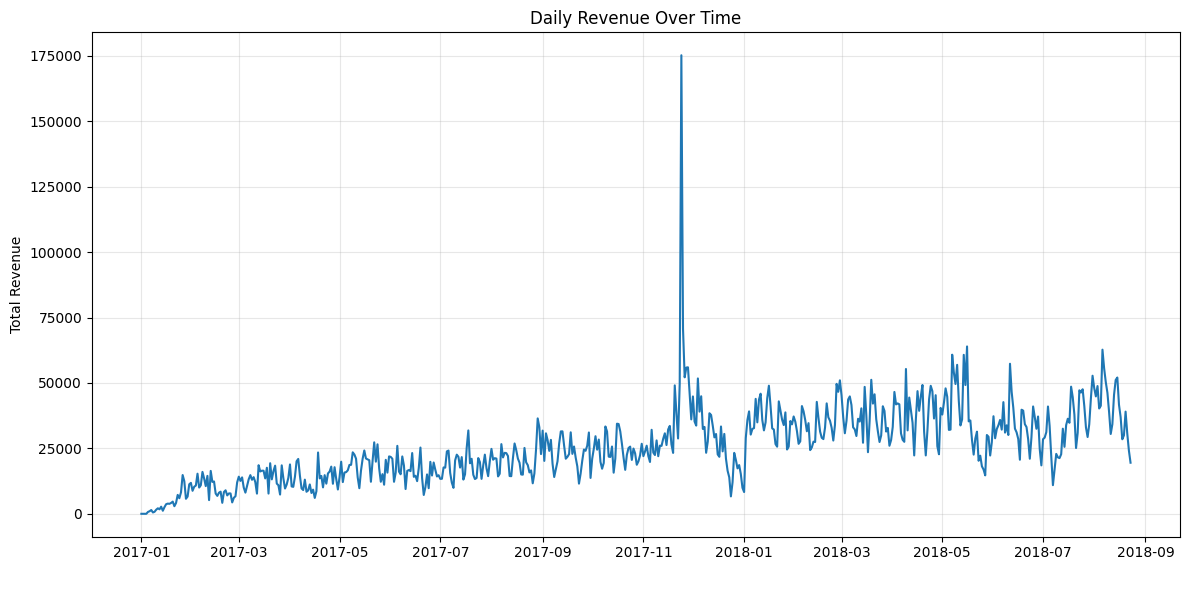

In [23]:
# Create a daily revenue over time graph
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['ds'], daily_revenue['y'], linestyle='-')

# Formatting
plt.title('Daily Revenue Over Time')
plt.xlabel(' ')
plt.ylabel('Total Revenue')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

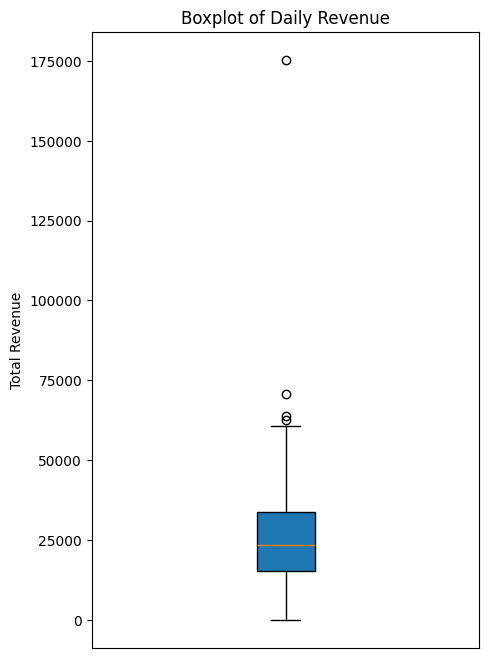

In [24]:
# Creating the boxplot
plt.figure(figsize=(5, 8))
plt.boxplot(daily_revenue['y'], vert=True, patch_artist=True)
plt.title('Boxplot of Daily Revenue')
plt.ylabel('Total Revenue')
plt.xticks([])
plt.show()

In [25]:
daily_revenue[daily_revenue['y'] > 60000].sort_values(by='y', ascending=False)

,ds,y
327,2017-11-24,175250.94
328,2017-11-25,70684.27
500,2018-05-16,63960.93
582,2018-08-06,62728.23
491,2018-05-07,60805.33
498,2018-05-14,60753.88


From the charts and the table above, it appears that daily revenue increase over time, with significant outliers observed during the Black Friday event (2017-11-24). I decided not to remove these outliers because the SARIMA model can account for them as exogenous variables.

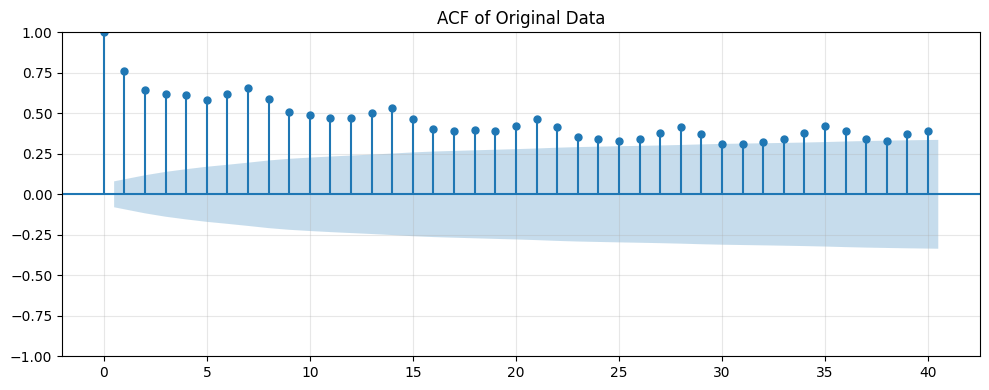

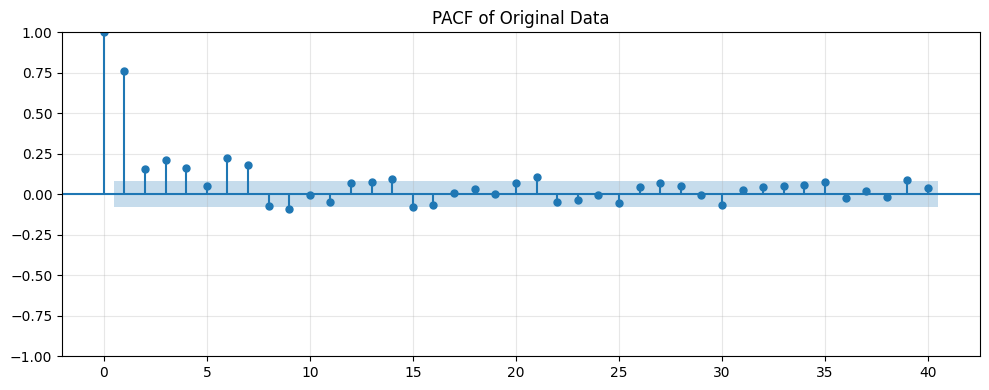

In [26]:
# ACF Plot with controlled figure size
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(daily_revenue['y'], lags=40, alpha=0.05, title='ACF of Original Data', ax=ax)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

# PACF Plot with controlled figure size
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(daily_revenue['y'], lags=40, alpha=0.05, title='PACF of Original Data', ax=ax)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

The ACF plot was used to determine the MA (Moving Average) part, or q term, of the SARIMA model, while the PACF plot was used to determine the AR (Autoregression) part, or p term, of the SARIMA model.

From the ACF and PACF plots above, it appears that the dataset exhibits weekly seasonality, as indicated by significant lags at multiples of 7, and possibly yearly seasonality (which will be further explored in another section).

The model diagnostics or residual analysis should address this effect by capturing the pattern, reducing significant lags near zero, or ensuring they fall within the confidence interval (blue-shaded region).

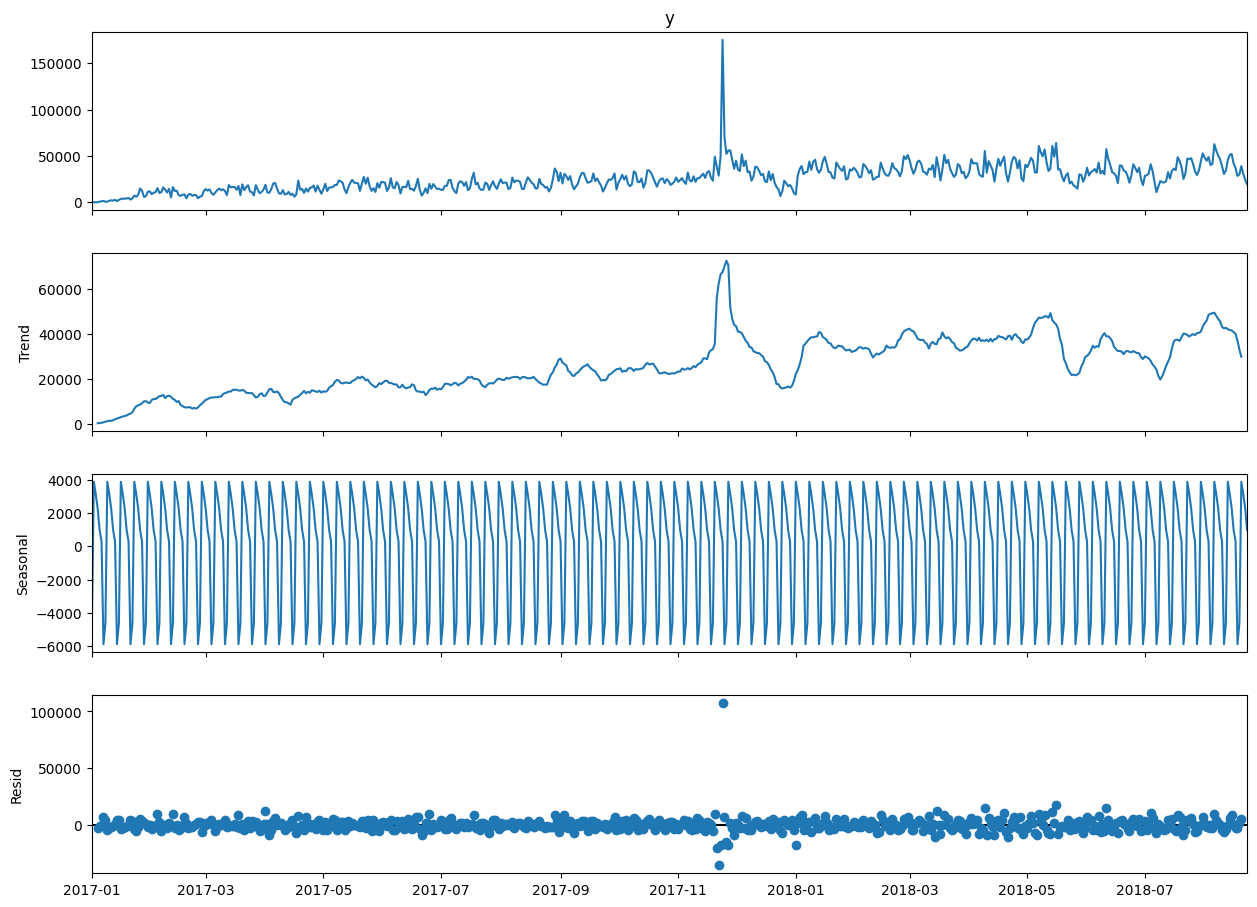

In [27]:
# Seasonal Decompose
daily_decompose = daily_revenue.set_index('ds')
daily_decompose = daily_decompose.asfreq('D')

decomposition = seasonal_decompose(daily_decompose['y'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

From the graph above, the trend increased over time and showed apparent weekly seasonality. The residuals highlighted the effect of outliers, such as those during Black Friday.

# Stationary Test

In [28]:
# Non-seasonal ADF test on original data
def adf_test(series, title=''):
    print(f'\nADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # Drop NA for test
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-Stationary"}')

In [29]:
adf_test(daily_revenue['y'], title='Original Data (Non-Seasonal)')


ADF Test: Original Data (Non-Seasonal)
ADF Statistic: -3.1256437806385087
p-value: 0.024712725930300272
Critical Values:
   1%: -3.4415970480373046
   5%: -2.866501759246704
   10%: -2.5694124827594296
Result: Stationary


In [30]:
decomposition = seasonal_decompose(daily_revenue.set_index('ds')['y'], period=7)  # period=S=7
residuals = decomposition.resid.dropna()

# Seasonal ADF test on residuals
adf_test(residuals, title='Residuals After Seasonal Decomposition (Seasonal)')


ADF Test: Residuals After Seasonal Decomposition (Seasonal)
ADF Statistic: -9.891095245544431
p-value: 3.5562947645608394e-17
Critical Values:
   1%: -3.4417938762914972
   5%: -2.866588428280353
   10%: -2.5694586650317475
Result: Stationary


The stationarity test using the ADF shows that the dataset is non-stationary, as indicated by the p-value < 0.05. However, this p-value (0.0247) for non-seasonal is close to the threshold, suggesting a borderline non-stationary behavior. Therefore, I attempted differencing to see if it improves the model's performance.

# Save the CSV Files for Deployment

In [31]:
# Save the last 30 days for creating synthetic dataset
revenue_to_save = daily_revenue.iloc[:-30].copy()
revenue_to_save.rename(columns={'ds': 'date', 'y': 'revenue_trend'}, inplace=True)

In [32]:
# Rename the column
last_30_days = daily_revenue.iloc[-30:].copy()
last_30_days.rename(columns={'ds': 'date', 'y': 'revenue_trend'}, inplace=True)

In [33]:
# Save DataFrame to CSV
save_csv_path = base_path
save_csv_path = Path(save_csv_path) / 'saved_csv'
save_csv_path.mkdir(parents=True, exist_ok=True)  # Create dir if missing

revenue_to_save.to_csv(save_csv_path / "revenue_trend.csv", index=False)
last_30_days.to_csv(save_csv_path / "revenue_trend_last_30_days.csv", index=False)

In [34]:
# print(last_30_days['revenue_trend'].to_string(index=False))

# Creating New Features

Creating new features representing the dates around the Black Friday event as exogenous variables in the SARIMA model.

In [35]:
def create_features(df):
    df = df.copy()

    # Generate Black Friday dates dynamically (fourth Friday of November)
    df['year'] = df['ds'].dt.year
    df['black_friday'] = df.apply(lambda row: pd.date_range(start=f'{row.year}-11-01', end=f'{row.year}-11-30', freq='WOM-4FRI')[0], axis=1)
    # ---- BLACK FRIDAY ----
    df['is_black_friday'] = (df['ds'].isin(['2017-11-24','2017-11-25'])).astype(int) # significant
    df['is_black_friday_peak'] = (df['ds'] == df['black_friday']).astype(int)  # significant. Black friday: 2017-11-24, ...
    df.drop(columns=['black_friday', 'year'], inplace=True)

    return df

# Train-Test Split

In [36]:
forecast_days = 30
split_date = daily_revenue['ds'].max() - pd.Timedelta(days=forecast_days)
train = daily_revenue[daily_revenue['ds'] <= split_date].copy()
test = daily_revenue[daily_revenue['ds'] > split_date].copy()

# Print min and max dates
print("Train date range:", train['ds'].min(), "to", train['ds'].max())
print("Test date range:", test['ds'].min(), "to", test['ds'].max())

Train date range: 2017-01-01 00:00:00 to 2018-07-24 00:00:00
Test date range: 2018-07-25 00:00:00 to 2018-08-23 00:00:00


In [37]:
train = create_features(train)
test = create_features(test)

# Add features to daily_revenue (for full-dataset retraining)
daily_revenue = create_features(daily_revenue.copy())

In [38]:
# Regressor Features
regressor_features = ['is_black_friday','is_black_friday_peak']

# Yeo-Johnson Transformation

In [39]:
# Initialize transformer
pt = PowerTransformer(method='yeo-johnson')

In [40]:
# Only fit to train set and transform to test and daily_revenue (avoiding data leakage)
train['y_transformed'] = pt.fit_transform(train[['y']]).flatten()
test['y_transformed'] = pt.transform(test[['y']]).flatten()
daily_revenue['y_transformed'] = pt.transform(daily_revenue[['y']]).flatten()

In [41]:
# Keep original 'y' (unchanged)
train['y_original'] = train['y']
test['y_original'] = test['y']
daily_revenue['y_original'] = daily_revenue['y']

# Hyperparameter Tuning using SARIMA

In [42]:
print("Performing SARIMA tuning...")

# Define individual parameter ranges
p_range = range(0, 2)      # AR order
d_range = [1]              # Differencing order
q_range = range(0, 2)      # MA order

P_range = range(0, 2)      # Seasonal AR order
D_range = [0]              # Seasonal differencing order
Q_range = range(0, 2)      # Seasonal MA order
S_range = [7]              # Seasonal period (weekly in this case)

# Create all combinations of non-seasonal parameters
pdq = list(itertools.product(p_range, d_range, q_range))

# Create all combinations of seasonal parameters
seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, S_range))

# Count combinations
print(f"Non-seasonal combinations: {len(pdq)}")
print(f"Seasonal combinations: {len(seasonal_pdq)}")
print(f"Total combinations: {len(pdq) * len(seasonal_pdq)}")

Performing SARIMA tuning...
Non-seasonal combinations: 4
Seasonal combinations: 4
Total combinations: 16


In [43]:
best_aic = np.inf
best_params = None
best_seasonal_params = None

# Prepare aligned endogenous and exogenous variables
endog = train['y_transformed'].reset_index(drop=True)
exog = train[regressor_features].reset_index(drop=True)

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(endog,
                          exog=exog,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=True,
                          initialization='approximate_diffuse'
                          )
            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal

            print(f"ARIMA{param}x{param_seasonal} - AIC:{results.aic:.2f}")
        except:
            continue

print(f"\nBest SARIMA params: {best_params}x{best_seasonal_params} - AIC: {best_aic:.2f}")

ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:839.28
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:915.99
ARIMA(0, 1, 0)x(1, 0, 0, 7) - AIC:893.49
ARIMA(0, 1, 0)x(1, 0, 1, 7) - AIC:784.87
ARIMA(0, 1, 1)x(0, 0, 0, 7) - AIC:784.17
ARIMA(0, 1, 1)x(0, 0, 1, 7) - AIC:837.62
ARIMA(0, 1, 1)x(1, 0, 0, 7) - AIC:783.70
ARIMA(0, 1, 1)x(1, 0, 1, 7) - AIC:662.65
ARIMA(1, 1, 0)x(0, 0, 0, 7) - AIC:822.62
ARIMA(1, 1, 0)x(0, 0, 1, 7) - AIC:872.61
ARIMA(1, 1, 0)x(1, 0, 0, 7) - AIC:847.16
ARIMA(1, 1, 0)x(1, 0, 1, 7) - AIC:706.06
ARIMA(1, 1, 1)x(0, 0, 0, 7) - AIC:739.17
ARIMA(1, 1, 1)x(0, 0, 1, 7) - AIC:804.38
ARIMA(1, 1, 1)x(1, 0, 0, 7) - AIC:775.03
ARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:663.46

Best SARIMA params: (0, 1, 1)x(1, 0, 1, 7) - AIC: 662.65


# Train the model using SARIMA

Since the SARIMA model performed poorly at the beginning of the periods due to the lack of prior sequence data, I burned in the first 10 periods to prevent bias and maintain model performance.

In [44]:
# Calculate burn-in period
p, d, q = best_params
P, D, Q, S = best_seasonal_params
burn_in = 10
print(f"Burn-in period: {burn_in} days")

Burn-in period: 10 days


In [45]:
# Train final SARIMA model
print("Training final SARIMA model...")

# Prepare aligned endogenous and exogenous variables
endog = train['y_transformed'].reset_index(drop=True)
exog = train[regressor_features].reset_index(drop=True)

final_sarima = SARIMAX(endog,
                       exog=exog,
                       order=best_params,
                       seasonal_order=best_seasonal_params,
                       enforce_stationarity=True,
                       enforce_invertibility=True,
                       initialization='approximate_diffuse'
                       )
sarima_results = final_sarima.fit(disp=False)

Training final SARIMA model...


## Save the Model for Deployment

Save the model for evaluating metrics during deployment.

In [46]:
save_model_path = base_path
saved_models_dir = Path(save_model_path) / 'saved_models'
saved_models_dir.mkdir(parents=True, exist_ok=True)  # Create dir if missing

# Get current time in GMT+7 (Asia/Bangkok, Asia/Jakarta, etc.)
tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(tz)

version = current_time.strftime("%Y%m%d_%H%M")
deploy_model_path = saved_models_dir / f'revenue_trend_sarima_eval_v{version}.joblib'

# Save both SARIMA model and PowerTransformer
deploy_artifact = {
    'model': sarima_results,
    'transformer': pt
}

# Save the model
joblib.dump(deploy_artifact, deploy_model_path)

print(f"✅ Model will be saved to: {deploy_model_path}")
print(f"Time used: {current_time} (GMT+7)")

✅ Model will be saved to: /content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/saved_models/revenue_trend_sarima_eval_v20250426_2231.joblib
Time used: 2025-04-26 22:31:25.948243+07:00 (GMT+7)


## Generate Forecast

In [47]:
# Prepare exogenous variables for the forecast period
exog_test = test[regressor_features]

# Before forecasting, ensure columns match
assert (exog_test.columns == train[regressor_features].columns).all()

**Baseline**

In [48]:
# Baseline Forecast (without rolling window): generate forecast with exogenous variables
sarima_forecast_baseline = sarima_results.get_forecast(
    steps=forecast_days,
    exog=exog_test
)

**1-Day Rolling Window**

In [49]:
# Generate a Forecast with a 1-Day Rolling Window

current_model = sarima_results
sarima_pred_transformed = []
sarima_ci_lower_transformed = []
sarima_ci_upper_transformed = []

# Iterate through each day in the test set
for i in range(len(test)):
    # Get exogenous variables for the next step (as a DataFrame row)
    exog_next = exog_test.iloc[i:i+1]

    # Forecast the next step
    forecast = current_model.get_forecast(steps=1, exog=exog_next)
    pred_transformed = forecast.predicted_mean.iloc[0]
    sarima_pred_transformed.append(pred_transformed)

    # --- Capture confidence intervals ---
    ci = forecast.conf_int().iloc[0]
    sarima_ci_lower_transformed.append(ci[0])
    sarima_ci_upper_transformed.append(ci[1])

    # Append actual observation and exog to update the model
    new_endog = test['y_transformed'].iloc[i]
    current_model = current_model.append([new_endog], exog=exog_next.values)

## Inverse Yeo-Johnson Transformation

**Baseline**

In [50]:
# Baseline Forecast
sarima_pred_baseline = pt.inverse_transform(
    sarima_forecast_baseline.predicted_mean.values.reshape(-1, 1)
).flatten()

# Inverse transform confidence intervals for test set
sarima_baseline_ci = sarima_forecast_baseline.conf_int(alpha=0.30) # 100% - 70% CI → alpha=0.30

# Inverse transform lower and upper bounds
sarima_baseline_ci_lower = pt.inverse_transform(
    sarima_baseline_ci.iloc[:, 0].values.reshape(-1, 1)
).flatten()

sarima_baseline_ci_upper = pt.inverse_transform(
    sarima_baseline_ci.iloc[:, 1].values.reshape(-1, 1)
).flatten()

**1-Day Rolling Window**

In [51]:
# Convert to array for inverse transform
sarima_pred_transformed = np.array(sarima_pred_transformed)

# Forecast with a 1-Day Rolling Window
sarima_pred = pt.inverse_transform(
    sarima_pred_transformed.reshape(-1, 1)
).flatten()

# Inverse transform confidence intervals for test set
sarima_ci_lower = pt.inverse_transform(
    np.array(sarima_ci_lower_transformed).reshape(-1, 1)
).flatten()
sarima_ci_upper = pt.inverse_transform(
    np.array(sarima_ci_upper_transformed).reshape(-1, 1)
).flatten()

## Residual Analysis

In [52]:
# SARIMA Residual Diagnostics
sarima_residuals = sarima_results.resid.iloc[burn_in:]  # burn-in dates

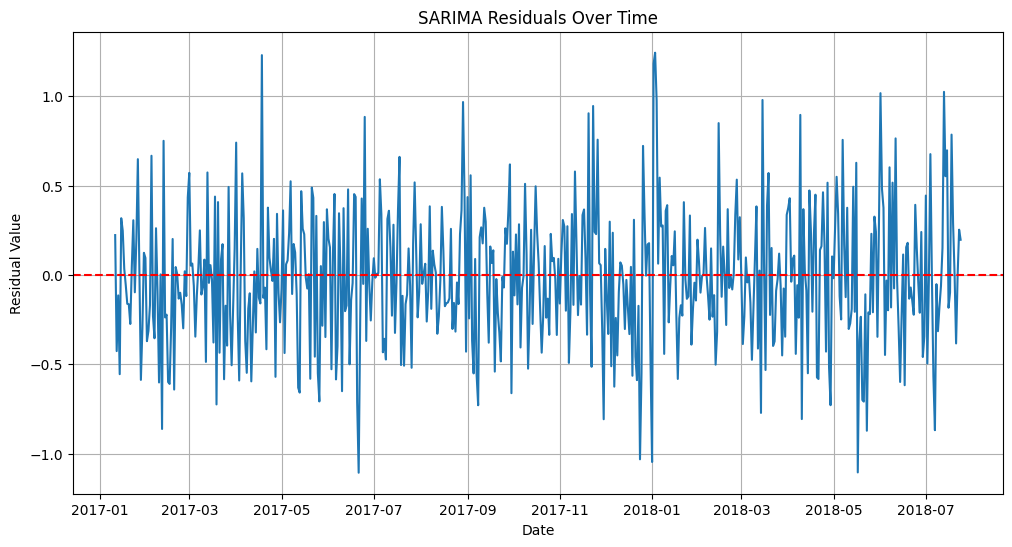

In [53]:
# Residuals vs Time
plt.figure(figsize=(12, 6))
plt.plot(train['ds'].iloc[burn_in:], sarima_residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('SARIMA Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

The SARIMA residuals over time did not exhibit autocorrelation, indicating that the model assumptions were satisfied.

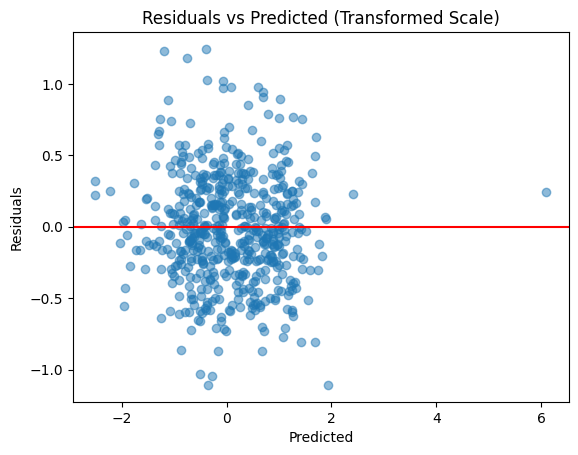

In [54]:
# Heteroscedasticity Check (Transformed Scale)
plt.scatter(sarima_results.fittedvalues.iloc[burn_in:], sarima_residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.title('Residuals vs Predicted (Transformed Scale)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

The heteroscedasticity check, which plotted residuals against predicted values, showed a scattered pattern with no discernible structure, indicating that the SARIMA model assumptions were met.

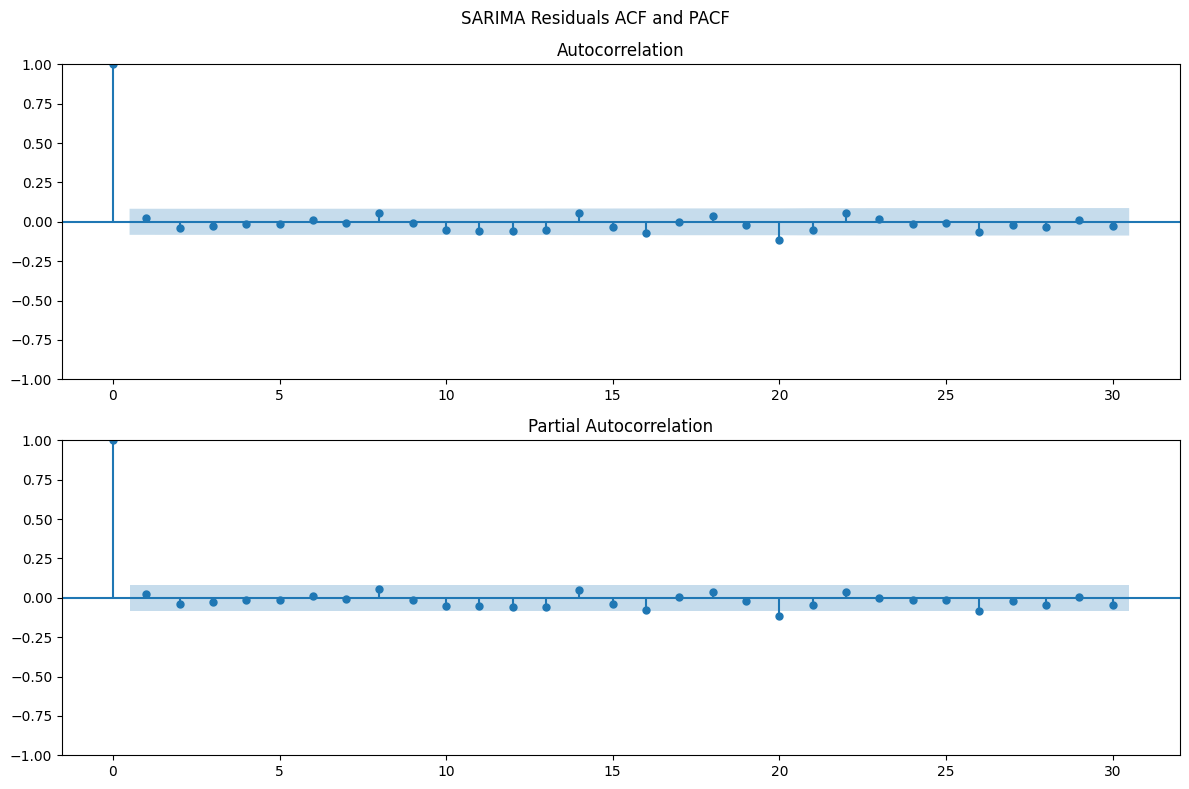

In [55]:
# ACF/PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(sarima_residuals, lags=30, alpha=0.05, ax=ax1)
plot_pacf(sarima_residuals, lags=30, alpha=0.05, ax=ax2)
plt.suptitle('SARIMA Residuals ACF and PACF')
plt.tight_layout()
plt.show()

The ACF and PACF plots showed values close to zero, indicating that the SARIMA model successfully captured all underlying patterns.

In [56]:
# Ljung-Box Test
max_lag = min(40, len(sarima_residuals)//4)
lb_test = acorr_ljungbox(sarima_residuals, lags=range(1,max_lag), return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.296285   0.586221
2    1.166026   0.558214
3    1.553327   0.670018
4    1.625211   0.804254
5    1.701657   0.888691
6    1.753843   0.940889
7    1.790918   0.970502
8    3.628084   0.889025
9    3.686679   0.930799
10   5.389057   0.863721
11   7.308624   0.773568
12   9.140645   0.690873
13  10.789315   0.628462
14  12.606124   0.557745
15  13.136874   0.591727
16  16.126176   0.444190
17  16.128280   0.514760
18  16.994493   0.523484
19  17.192732   0.576812
20  25.052808   0.199418
21  26.486377   0.188507
22  28.455246   0.161080
23  28.614367   0.193437
24  28.729252   0.230487
25  28.771510   0.273580
26  31.290774   0.217618
27  31.482068   0.251809
28  32.196944   0.266571
29  32.284413   0.307529
30  32.632181   0.338725
31  32.662032   0.385203
32  32.762532   0.429416
33  33.294483   0.452932
34  33.565888   0.488762
35  33.961144   0.518118
36  34.045434   0.561836
37  34.200036   0.601020
38  38.349319   0.453646
3

The Ljung-Box test showed a p-value greater than 0.05, further confirming that the model effectively captured all relevant patterns.

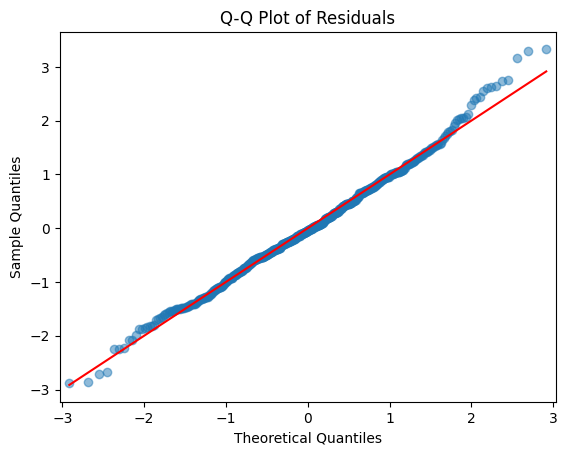

In [57]:
# Normality of Residuals
qqplot(sarima_residuals, line='s', fit=True, alpha=0.5)
plt.title('Q-Q Plot of Residuals')
plt.show()

The normality of the residuals, as indicated by the Q-Q plots, showed that the points closely overlapped the red straight line, suggesting that the residuals followed a normal distribution and thus satisfied the SARIMA model assumptions.

In [58]:
# ADF Test on Residuals
adf_test(sarima_residuals, title='Model Residuals (Transformed)')


ADF Test: Model Residuals (Transformed)
ADF Statistic: -23.066946695007445
p-value: 0.0
Critical Values:
   1%: -3.442102384299813
   5%: -2.8667242618524233
   10%: -2.569531046591633
Result: Stationary


After differencing with order d=1, the residuals has a p-value approaching zero, indicating that the model is stationary.

## Model Evaluation

In [59]:
def smape(true, pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)"""
    true = np.array(true)
    pred = np.array(pred)
    # Avoid division by zero by adding a small constant if needed
    denominator = (np.abs(true) + np.abs(pred))
    # When both true and pred are zero, the error is zero
    smape_val = np.where(denominator == 0,
                         0.0,
                         200 * np.abs(pred - true) / denominator)
    return np.mean(smape_val)

In [60]:
def calculate_metrics(true, pred, model_name):
    mask = true != 0  # Only calculate for non-zero actuals
    mape = np.mean(np.abs((true[mask] - pred[mask]) / true[mask])) * 100

    metrics = {
        'Model': model_name,
        'MSE': mean_squared_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'MAPE': mape,
        'SMAPE': smape(true, pred)
    }
    return metrics

In [61]:
# Get training predictions AFTER burn-in (skip unstable initial points)
pred = sarima_results.get_prediction(start=burn_in)
sarima_train_pred_transformed = pred.predicted_mean

# Capture training confidence intervals
train_ci_transformed = pred.conf_int()

# Align actuals (skip burn-in days)
actuals_train = train['y_original'].iloc[burn_in:]

# Inverse transform to original scale
sarima_train_pred = pt.inverse_transform(
    sarima_train_pred_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

# Inverse transform training confidence intervals
sarima_train_ci_lower = pt.inverse_transform(
    train_ci_transformed.iloc[:, 0].values.reshape(-1, 1)
).flatten().clip(min=0)
sarima_train_ci_upper = pt.inverse_transform(
    train_ci_transformed.iloc[:, 1].values.reshape(-1, 1)
).flatten().clip(min=0)

In [62]:
# Align lengths between actuals and predictions
if len(actuals_train) != len(sarima_train_pred):
    min_length = min(len(actuals_train), len(sarima_train_pred))
    actuals_train = actuals_train.iloc[:min_length]
    sarima_train_pred = sarima_train_pred[:min_length]

In [63]:
# Calculate metrics
sarima_train_metrics = calculate_metrics(actuals_train, sarima_train_pred, 'SARIMA (Train)')
sarima_test_metrics = calculate_metrics(test['y_original'], sarima_pred, 'SARIMA (Test - 1-Day Rolling Window)')
sarima_test_baseline_metrics = calculate_metrics(test['y_original'], sarima_pred_baseline, 'SARIMA (Test - Baseline)')

**Baseline (added a new metrics)**

In [64]:
# New Metrics for Baseline test set
# PIC & PIW
within_ci_baseline = (test['y_original'] >= sarima_baseline_ci_lower) & (test['y_original'] <= sarima_baseline_ci_upper)
pic_test_baseline = np.mean(within_ci_baseline) * 100
piw_test_baseline = np.mean(sarima_baseline_ci_upper - sarima_baseline_ci_lower)

# MDA
prev_actual_baseline = train['y_original'].iloc[-1]
mda_correct_baseline = 0
for i in range(len(test)):
    current_actual_baseline = test['y_original'].iloc[i]
    current_pred_baseline = sarima_pred_baseline[i]
    actual_dir_baseline = current_actual_baseline > prev_actual_baseline
    forecast_dir_baseline = current_pred_baseline > prev_actual_baseline
    if actual_dir_baseline == forecast_dir_baseline:
        mda_correct_baseline += 1
    prev_actual_baseline = current_actual_baseline
mda_test_baseline = (mda_correct_baseline / len(test)) * 100

# Forecast Bias
forecast_bias_test_baseline = np.mean(test['y_original'] - sarima_pred_baseline)

# Update test metrics
sarima_test_baseline_metrics['PIW'] = piw_test_baseline
sarima_test_baseline_metrics['PIC'] = pic_test_baseline
sarima_test_baseline_metrics['MDA'] = mda_test_baseline
sarima_test_baseline_metrics['Forecast Bias'] = forecast_bias_test_baseline

**1-Day Rolling Window (added a new metrics)**

In [65]:
# New Metrics for test set
# PIC & PIW
within_ci = (test['y_original'] >= sarima_ci_lower) & (test['y_original'] <= sarima_ci_upper)
pic_test = np.mean(within_ci) * 100
piw_test = np.mean(sarima_ci_upper - sarima_ci_lower)

# MDA
prev_actual = train['y_original'].iloc[-1]
mda_correct = 0
for i in range(len(test)):
    current_actual = test['y_original'].iloc[i]
    current_pred = sarima_pred[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct += 1
    prev_actual = current_actual
mda_test = (mda_correct / len(test)) * 100

# Forecast Bias
forecast_bias_test = np.mean(test['y_original'] - sarima_pred)

# Update test metrics
sarima_test_metrics['PIW'] = piw_test
sarima_test_metrics['PIC'] = pic_test
sarima_test_metrics['MDA'] = mda_test
sarima_test_metrics['Forecast Bias'] = forecast_bias_test

In [66]:
# Compute new metrics for training set
# PIC & PIW
within_ci_train = (actuals_train >= sarima_train_ci_lower) & (actuals_train <= sarima_train_ci_upper)
pic_train = np.mean(within_ci_train) * 100
piw_train = np.mean(sarima_train_ci_upper - sarima_train_ci_lower)

# MDA
prev_actual = train['y_original'].iloc[burn_in - 1] if burn_in > 0 else actuals_train.iloc[0]
mda_correct_train = 0
for i in range(len(actuals_train)):
    current_actual = actuals_train.iloc[i]
    current_pred = sarima_train_pred[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct_train += 1
    prev_actual = current_actual
mda_train = (mda_correct_train / len(actuals_train)) * 100

# Forecast Bias
forecast_bias_train = np.mean(actuals_train - sarima_train_pred)

# Update train metrics
sarima_train_metrics['PIW'] = piw_train
sarima_train_metrics['PIC'] = pic_train
sarima_train_metrics['MDA'] = mda_train
sarima_train_metrics['Forecast Bias'] = forecast_bias_train

In [67]:
# Combine results
results_df = pd.DataFrame([sarima_train_metrics, sarima_test_baseline_metrics, sarima_test_metrics])

In [68]:
# Overfitting check
train_rmse = sarima_train_metrics['RMSE']
test_rmse = sarima_test_metrics['RMSE']

train_rel_error = (train_rmse / train['y_original'].iloc[burn_in:].mean()) * 100
test_rel_error = (test_rmse / test['y_original'].iloc[burn_in:].mean()) * 100

print(f"Train RMSE: R${train_rmse:,.0f}")
print(f"Test RMSE: R${test_rmse:,.0f}")
print(f"Average Daily Revenue on the Train Set: R${train['y_original'].mean():,.0f}")
print(f"Average Daily Revenue on the Test Set: R${test['y_original'].mean():,.0f}")
print(f"Train RMSE Relative Error: {train_rel_error:.2f}%")
print(f"Test RMSE Relative Error: {test_rel_error:.2f}%")

gap_train_test = test_rel_error - train_rel_error

if gap_train_test > 10:
    print(f"\nThe test error is {gap_train_test:.2f}% worse than the training error.")
    print("⚠️ Warning: Potential overfitting detected (Train-Test RMSE Gap >10%).")
elif gap_train_test < 0:
    print(f"\n✅ The test error is {abs(gap_train_test):.2f}% better than the training error.")
else:
    print(f"\nThe test error is {gap_train_test:.2f}% worse than the training error.")
    print("✅ No significant overfitting detected (Train-Test RMSE Gap ≤10%).")


Train RMSE: R$5,333
Test RMSE: R$5,458
Average Daily Revenue on the Train Set: R$24,751
Average Daily Revenue on the Test Set: R$40,787
Train RMSE Relative Error: 21.18%
Test RMSE Relative Error: 13.65%

✅ The test error is 7.52% better than the training error.


In [69]:
print("=== Model Performance ===")
print(results_df.to_markdown(tablefmt="grid", index=False))

=== Model Performance ===
+--------------------------------------+-------------+---------+---------+---------+---------+---------+---------+---------+-----------------+
| Model                                |         MSE |    RMSE |     MAE |    MAPE |   SMAPE |     PIW |     PIC |     MDA |   Forecast Bias |
+======================================+=============+=========+=========+=========+=========+=========+=========+=========+=================+
| SARIMA (Train)                       | 2.84384e+07 | 5332.76 | 4070.63 | 19.984  | 18.5525 | 20225.5 | 95.1786 | 76.4286 |        -42.7769 |
+--------------------------------------+-------------+---------+---------+---------+---------+---------+---------+---------+-----------------+
| SARIMA (Test - Baseline)             | 7.84801e+07 | 8858.9  | 6442.99 | 19.0495 | 16.1856 | 27106.9 | 90      | 76.6667 |       -844.05   |
+--------------------------------------+-------------+---------+---------+---------+---------+---------+---------+--

From the metrics above, I chose RMSE as my priority metric because the dataset contains outliers (around the Black Friday events), and I wanted to penalize this effect. MAP or SMAPE is not accurate for this dataset because it contains zero or near-zero values.

I chose the evaluation metrics from the 1-day rolling window instead of the baseline forecast because it is more accurate.
- RMSE is 5,458, meaning that, on average, predictions are off by R\$5,458 revenue/day.
- PIW (Prediction Interval Width) is 26,066 for the 1-day rolling window, meaning that prediction ranges are R\$26,066 revenue wide (e.g., R\$10,000–R\$36,066).
- PIC (Prediction Interval Coverage) is 97, meaning 97% of actual sales fall within the predicted range.
- MDA (Mean Directional Accuracy) is 70, meaning that 70% of trend predictions (up/down compared to yesterday) are correct.
- Forecast bias (deviation) is -1,454, meaning the model tends to underpredict by R$1,454 revenue.

In [70]:
print(sarima_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     y_transformed   No. Observations:                  570
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -325.325
Date:                           Sat, 26 Apr 2025   AIC                            662.649
Time:                                   15:31:27   BIC                            688.723
Sample:                                        0   HQIC                           672.822
                                           - 570                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_black_friday          1.6345      0.366      4.460      0.000       0.916       2.353
is_black_frid

As we can see from the model summary, the model has the best parameters (1, 1, 1) × (1, 0, 1, 7) (p, d, q) × (P, D, Q, S). All the features, such as is_black_friday and is_black_friday_peak, show significant effects, as indicated by very low p-values (P > |z|). The probability from the Ljung-Box test being greater than 0.05 indicates that the residuals are white noise.

## Model Visualization

In [71]:
# Preparing the train set
train_dates = train['ds'].iloc[d:]  # d = differencing order

# Get aligned dates, actuals, and predictions AFTER burn-in
train_dates = train['ds'].iloc[burn_in:burn_in + len(sarima_train_pred)]
actuals_train = train['y_original'].iloc[burn_in:burn_in + len(sarima_train_pred)]

# Create DataFrame for train forecasts
train_forecast_df = pd.DataFrame({
    'ds': train_dates,
    'y_true': actuals_train,
    'y_pred': sarima_train_pred
})

# Black Fridays
black_friday_dates = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(['2017-11-24'])
})

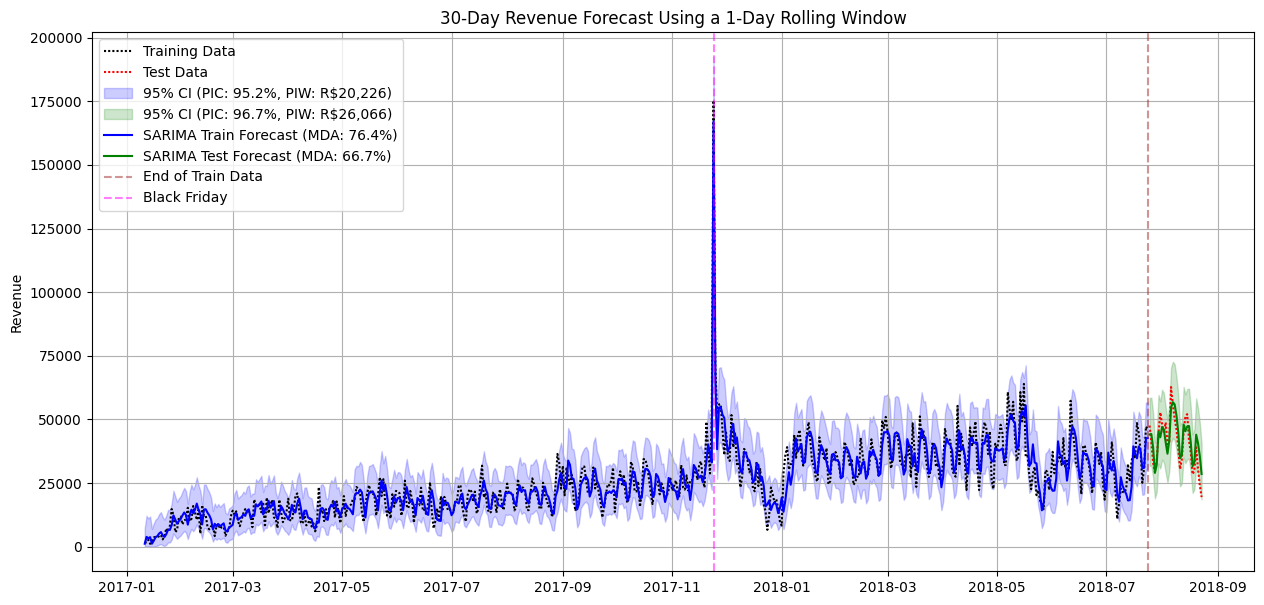

In [72]:
# Create 30-Day Revenue Forecast Chart
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train['ds'].iloc[burn_in:], train['y_original'].iloc[burn_in:], label='Training Data', linestyle=(0, (1, 1)), color='black')

# Plot test data
plt.plot(test['ds'], test['y_original'], label='Test Data', linestyle=(0, (1, 1)), color='red')

# Add shaded confidence intervals to the full dataset plot
plt.fill_between(train['ds'].iloc[burn_in:], sarima_train_ci_lower, sarima_train_ci_upper,
    color='blue', alpha=0.2,label=f'95% CI (PIC: {pic_train:.1f}%, PIW: R${piw_train:,.0f})')

plt.fill_between(test['ds'], sarima_ci_lower, sarima_ci_upper, color='green', alpha=0.2, label=f'95% CI (PIC: {pic_test:.1f}%, PIW: R${piw_test:,.0f})')

# Plot train forecasts
plt.plot(train_forecast_df['ds'], train_forecast_df['y_pred'], label=f'SARIMA Train Forecast (MDA: {mda_train:.1f}%)', color='blue')

# Plot test forecasts
plt.plot(test['ds'], sarima_pred, label=f'SARIMA Test Forecast (MDA: {mda_test:.1f}%)', color='green')

# Highlight key dates
plt.axvline(x=split_date, color='brown', linestyle='--', alpha=0.5, label='End of Train Data')

# Black Friday markers (optional)
bf_date = pd.to_datetime('2017-11-24')
if bf_date in train['ds'].values:
    plt.axvline(x=bf_date, color='magenta', linestyle='--', alpha=0.5, label='Black Friday')

# Formatting
plt.title('30-Day Revenue Forecast Using a 1-Day Rolling Window')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

From the graph above, the 1-day rolling window successfully forecasted the test data and closely matches the actual values.

In [73]:
print("="*50)
print("SARIMA Eval Baseline Forecast:")
print("="*50)
print(pd.DataFrame({
    'date': test['ds'],
    'forecast': sarima_pred_baseline,
    'lower_ci': sarima_baseline_ci_lower,
    'upper_ci': sarima_baseline_ci_upper
}))

SARIMA Eval Baseline Forecast:
          date      forecast      lower_ci      upper_ci
570 2018-07-25  44132.807546  37328.327475  51451.714677
571 2018-07-26  42823.884863  35533.398212  50728.063699
572 2018-07-27  38842.121801  31376.220888  47025.871063
573 2018-07-28  31322.735443  24172.771650  39305.284767
574 2018-07-29  34430.306180  26530.087613  43255.872585
575 2018-07-30  46792.926951  37169.540653  57413.531411
576 2018-07-31  45010.926689  35142.906474  55977.113277
577 2018-08-01  44721.710150  34373.343303  56293.742985
578 2018-08-02  43404.812466  32790.186335  55355.719620
579 2018-08-03  39397.936262  28899.079063  51355.087487
580 2018-08-04  31826.963380  22061.583918  43191.474296
581 2018-08-05  34956.593567  24398.359378  47211.955249
582 2018-08-06  47397.648482  34749.838923  61805.004896
583 2018-08-07  45605.107356  32847.443499  60237.305733
584 2018-08-08  45314.158696  32174.237670  60467.411954
585 2018-08-09  43989.295730  30690.161102  59428.551218


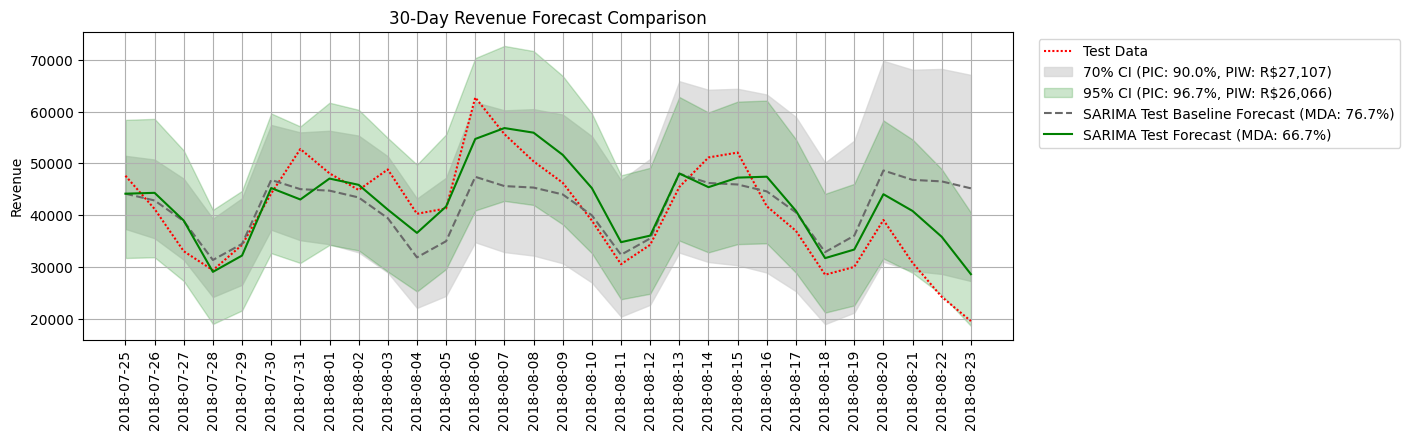

In [74]:
# Create 30-Day Revenue Forecast Comparison Chart
plt.figure(figsize=(12, 4))

# Plot test data (actual values)
plt.plot(test['ds'], test['y_original'], label='Test Data', linestyle=(0, (1, 1)), color='red')

# Plot baseline confidence interval
plt.fill_between(test['ds'], sarima_baseline_ci_lower, sarima_baseline_ci_upper, color='lightgray', alpha=0.7,
                label=f'70% CI (PIC: {pic_test_baseline:.1f}%, PIW: R${piw_test_baseline:,.0f})')

# Plot confidence interval
plt.fill_between(test['ds'], sarima_ci_lower, sarima_ci_upper, color='green', alpha=0.2,
                label=f'95% CI (PIC: {pic_test:.1f}%, PIW: R${piw_test:,.0f})')

# Plot baseline test forecasts
plt.plot(test['ds'], sarima_pred_baseline, label=f'SARIMA Test Baseline Forecast (MDA: {mda_test_baseline:.1f}%)', color='dimgray', linestyle='--')

# Plot test forecasts
plt.plot(test['ds'], sarima_pred, label=f'SARIMA Test Forecast (MDA: {mda_test:.1f}%)', color='green')

# Formatting
plt.title('30-Day Revenue Forecast Comparison')
plt.ylabel('Revenue')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(test['ds'], rotation=90)
plt.grid(True)
plt.show()

From the graph above, we can see that the baseline forecast was added to allow comparison with the 1-day rolling window forecast. Although the baseline forecast does not include 1-day self-correction like the rolling forecast, its performance still looks good, as indicated by the overlapping confidence interval with the test data.

In [75]:
# Training data (after burn-in)
actual_train = train[['ds', 'y_original']].iloc[burn_in:].rename(
    columns={'y_original': 'actual'}
)

# Test data
actual_test = test[['ds', 'y_original']].rename(
    columns={'y_original': 'actual'}
)

# Combine both
actual_df = pd.concat([actual_train, actual_test])

In [76]:
# Training forecast
train_forecast = pd.DataFrame({
    'ds': train['ds'].iloc[burn_in:],
    'forecast': train_forecast_df['y_pred'],
    'ci_lower': sarima_train_ci_lower,
    'ci_upper': sarima_train_ci_upper
})

# Test forecast
test_forecast = pd.DataFrame({
    'ds': test['ds'],
    'forecast': sarima_pred,
    'ci_lower': sarima_ci_lower,
    'ci_upper': sarima_ci_upper
})

# Combine both
forecast_df = pd.concat([train_forecast, test_forecast])

In [77]:
# Merge data first to ensure alignment
merged = pd.merge(
    actual_df[['ds', 'actual']],
    forecast_df[['ds', 'forecast']],
    on='ds',
    how='inner'
)

In [78]:
def plot_forecast_vs_actual_revenue(merged, year=None, month=None,
                                  show_trend_line=True, show_all_daily_ticks=False):
    """
    Plot daily olist revenue forecast accuracy (actual = baseline).

    Parameters:
    - merged: DataFrame containing actual and forecast data with 'ds', 'actual', and 'forecast' columns
    - year/month: Filter to specific month (e.g., March 2024)
    - show_trend_line: Add a line connecting daily deviations (default: True)
    - show_all_daily_ticks: Show every date label (default: False)
    """

    if year and month:
        merged = merged[(merged['ds'].dt.year == year) &
                       (merged['ds'].dt.month == month)]
        if merged.empty:
            print(f"No data for {month}/{year}")
            return

    # Calculate forecast deviation (forecast - actual)
    deviation = merged['forecast'] - merged['actual']

    # Create plot
    plt.figure(figsize=(12, 5))

    # Plot deviations
    over_mask = deviation > 0
    under_mask = deviation < 0
    plt.scatter(merged['ds'][over_mask], deviation[over_mask],
                color='green', marker='o', alpha=0.7, label='Forecast too high')
    plt.scatter(merged['ds'][under_mask], deviation[under_mask],
                color='red', marker='o', alpha=0.7, label='Forecast too low')

    # Reference lines
    plt.axhline(0, color='black', linestyle='-', alpha=0.3, label='Actual Revenue (normalized)')
    plt.axhline(deviation.mean(), color='magenta', linestyle='--',
                label=f'Avg Deviation: R${deviation.mean():,.0f} revenue/day')

    # Trend line (optional)
    if show_trend_line:
        plt.plot(merged['ds'], deviation, 'b--', alpha=0.5, linewidth=1,
                label='Deviation Trend')

    # Formatting
    title = 'Daily Olist Revenue: Forecast vs Actual'
    if year and month:
        title += f' ({month_name[month]} {year})'
        if show_all_daily_ticks:
            plt.xticks(merged['ds'], rotation=0, fontsize=10)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        else:
            plt.xticks(rotation=0)
    else:
        title += ' (All Historical Data)'

    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('Forecast Deviation', fontsize=10)
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

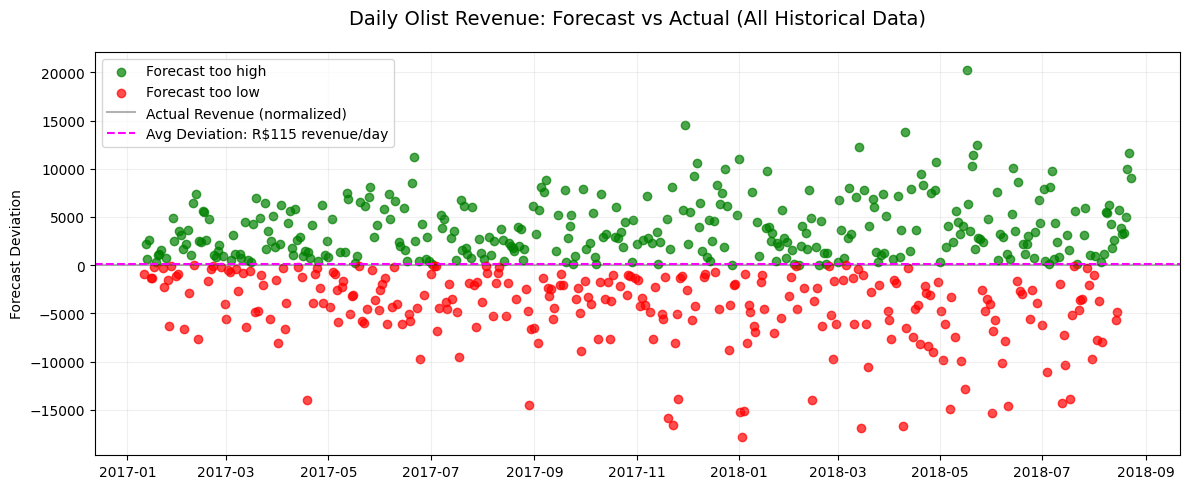

In [79]:
plot_forecast_vs_actual_revenue(merged, show_trend_line=False)

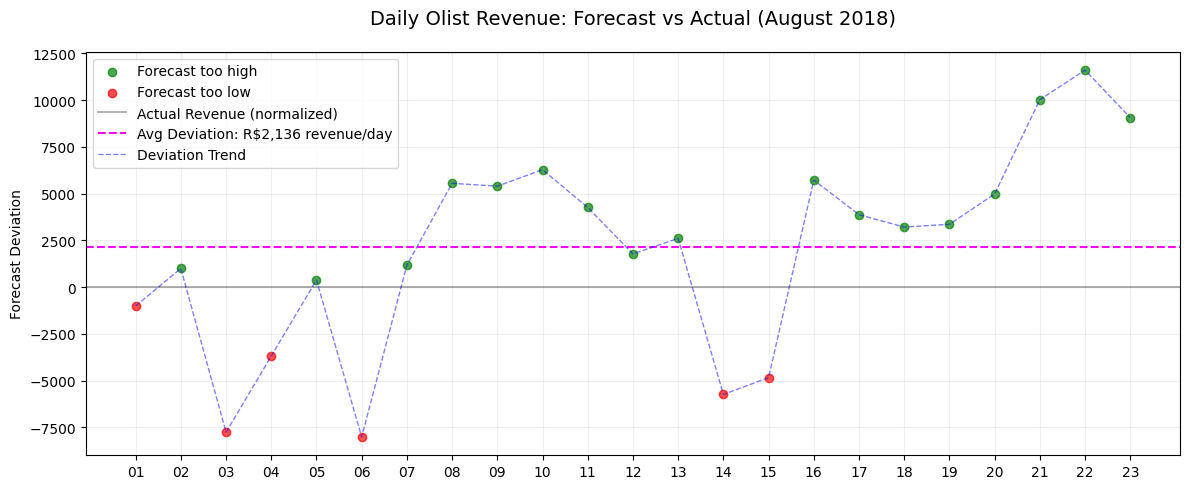

In [80]:
plot_forecast_vs_actual_revenue(merged, 2018, 8, show_all_daily_ticks=True)

From the graph above, the actual revenue was normalized to 0, and we can see where the forecast for each day was too high (green) or too low (red). The average deviation was R\$2,136 revenue per day.

## Business Impact Translation

In [81]:
# Convert RMSE to business metrics
avg_revenue = test['y_original'].mean()
rmse_value = float(results_df['RMSE'][2])
relative_rmse = (rmse_value / avg_revenue) * 100  # Percentage of average revenue
exchange_rate = 5.81  # 1 USD = 5.81 Brazilian Reais -> 18/04/2025

print("="*85)
print("BUSINESS IMPACT ANALYSIS (30-Day Revenue Forecast Using a 1-Day Rolling Window)")
print("="*85)
print(f"Average Daily Revenue: R${avg_revenue:,.0f}")
print(f"Average Deviation: R${rmse_value:,.0f} revenue ({relative_rmse:.1f}% of average) (${rmse_value / exchange_rate:,.0f} per day)")

# Error cost analysis (in local currency)
profit_margin = 0.5  # 50% profit margin on revenue
excess_holding_cost = 0.3  # 30% holding cost on excess inventory

under_prediction_cost = profit_margin * 100  # R$50 lost profit per R$100 under-prediction
over_prediction_cost = excess_holding_cost * 100  # R$30 excess cost per R$100 over-prediction

# Calculate prediction errors (in R$)
errors = np.array([sarima_pred[i] - test['y_original'].iloc[i] for i in range(len(test))])

# Calculate monetary impact of errors (using percentage-based costs)
weighted_errors = np.where(
    errors > 0,  # Over-prediction
    (over_prediction_cost/100) * abs(errors),  # 30% of over-predicted amount
    (under_prediction_cost/100) * abs(errors)  # 50% of under-predicted amount
)

avg_daily_cost = weighted_errors.mean()

print("\n" + "="*85)
print("ERROR COST ANALYSIS (LOCAL CURRENCY - R$)")
print("="*85)
print(f"Under-prediction Cost: R${under_prediction_cost:.0f} per R$100 error (lost profit)")
print(f"Over-prediction Cost: R${over_prediction_cost:.0f} per R$100 error (excess inventory)")
print(f"Daily Average Cost: R${avg_daily_cost:,.0f}")
print(f"Monthly Error Cost Impact: R${avg_daily_cost * 30:,.0f}")

print("\n" + "="*85)
print("ERROR COST ANALYSIS (USD $)")
print("="*85)
print(f"Under-prediction Cost: ${under_prediction_cost / exchange_rate:,.0f} per R$100 error")
print(f"Over-prediction Cost: ${over_prediction_cost / exchange_rate:,.0f} per R$100 error")
print(f"Daily Average Cost: ${avg_daily_cost / exchange_rate:,.0f}")
print(f"Monthly Error Cost Impact: ${avg_daily_cost * 30 / exchange_rate:,.0f}")
print("="*85)

BUSINESS IMPACT ANALYSIS (30-Day Revenue Forecast Using a 1-Day Rolling Window)
Average Daily Revenue: R$40,787
Average Deviation: R$5,458 revenue (13.4% of average) ($939 per day)

ERROR COST ANALYSIS (LOCAL CURRENCY - R$)
Under-prediction Cost: R$50 per R$100 error (lost profit)
Over-prediction Cost: R$30 per R$100 error (excess inventory)
Daily Average Cost: R$1,680
Monthly Error Cost Impact: R$50,415

ERROR COST ANALYSIS (USD $)
Under-prediction Cost: $9 per R$100 error
Over-prediction Cost: $5 per R$100 error
Daily Average Cost: $289
Monthly Error Cost Impact: $8,677


# Retrain the Model on Full Dataset

## Yeo-Johnson Transformation

In [82]:
# Initialize transformer
pt_full = PowerTransformer(method='yeo-johnson')

In [83]:
# Appyling fit_transform on full dataset
daily_revenue['y_transformed'] = pt_full.fit_transform(daily_revenue[['y']]).flatten()

In [84]:
# Keep original 'y' (unchanged)
daily_revenue['y_original'] = daily_revenue['y']

## Retrain the model using SARIMA on Full Dataset

In [85]:
print("Retraining SARIMA on full dataset...")

endog_full = daily_revenue['y_transformed'].reset_index(drop=True)
exog_full = daily_revenue[regressor_features].reset_index(drop=True)

final_sarima_full = SARIMAX(
    endog_full,
    exog=exog_full,
    order=best_params,
    seasonal_order=best_seasonal_params,
    enforce_stationarity=True,
    enforce_invertibility=True
)

sarima_full_results = final_sarima_full.fit(disp=False)

Retraining SARIMA on full dataset...


## Save the Model for Deployment

In [86]:
save_model_path = base_path
saved_models_dir = Path(save_model_path) / 'saved_models'
saved_models_dir.mkdir(parents=True, exist_ok=True)  # Create dir if missing

# Get current time in GMT+7 (Asia/Bangkok, Asia/Jakarta, etc.)
tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(tz)

version = current_time.strftime("%Y%m%d_%H%M")
deploy_model_path = saved_models_dir / f'revenue_trend_sarima_full_v{version}.joblib'

# Save both SARIMA model and PowerTransformer
deploy_artifact = {
    'model': sarima_full_results,
    'transformer': pt_full
}

# Save the model
joblib.dump(deploy_artifact, deploy_model_path)

print(f"✅ Model will be saved to: {deploy_model_path}")
print(f"Time used: {current_time} (GMT+7)")

✅ Model will be saved to: /content/drive/MyDrive/dibimbing.id/Day44 - Final Project Data Science/Project/saved_models/revenue_trend_sarima_full_v20250426_2231.joblib
Time used: 2025-04-26 22:31:31.345875+07:00 (GMT+7)


## Generate Forecast

In [87]:
# Generate future dates for next 30 days
last_date = daily_revenue['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create DataFrame with future dates
future_df = pd.DataFrame({'ds': future_dates})

# Generate features (MUST use same create_features() as training)
future_df = create_features(future_df)  # This now handles dynamic Black Fridays
future_exog = future_df[regressor_features]  # Align columns with training

In [88]:
forecast = sarima_full_results.get_forecast(
    steps=len(future_dates),
    exog=future_exog  # Pass pre-generated exogenous vars
)

In [89]:
# Get predictions and confidence intervals
future_pred_transformed = forecast.predicted_mean

# I think there's a 30% chance the true value falls outside this range.
future_ci = forecast.conf_int(alpha=0.30)  # 100% - 70% CI → alpha=0.30

## Inverse Yeo-Johnson Transformation

In [90]:
future_pred = pt_full.inverse_transform(
    future_pred_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

In [91]:
sarima_beyond_ci_lower = pt_full.inverse_transform(future_ci.iloc[:, 0].values.reshape(-1, 1)).flatten()
sarima_beyond_ci_upper = pt_full.inverse_transform(future_ci.iloc[:, 1].values.reshape(-1, 1)).flatten()

# Verify lengths
assert len(future_pred) == len(sarima_beyond_ci_lower) == len(sarima_beyond_ci_upper) == 30

In [92]:
# Prepare final output DataFrame
sarima_future_forecast = pd.DataFrame({
    'ds': future_dates,
    'yhat': future_pred,
    'yhat_lower': sarima_beyond_ci_lower,
    'yhat_upper': sarima_beyond_ci_upper
})

## Residual Analysis

In [93]:
# Get residuals AFTER burn-in period
full_residuals = sarima_full_results.resid.iloc[burn_in:]

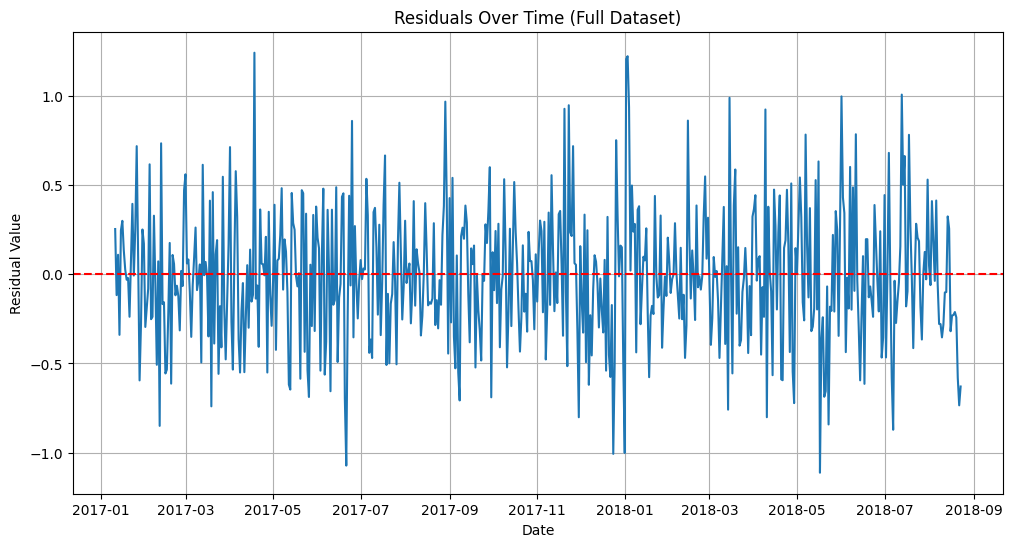

In [94]:
# Residual Plots (Transformed Scale)
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['ds'].iloc[burn_in:], full_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time (Full Dataset)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

The SARIMA residuals over time did not exhibit autocorrelation, indicating that the model assumptions were satisfied.

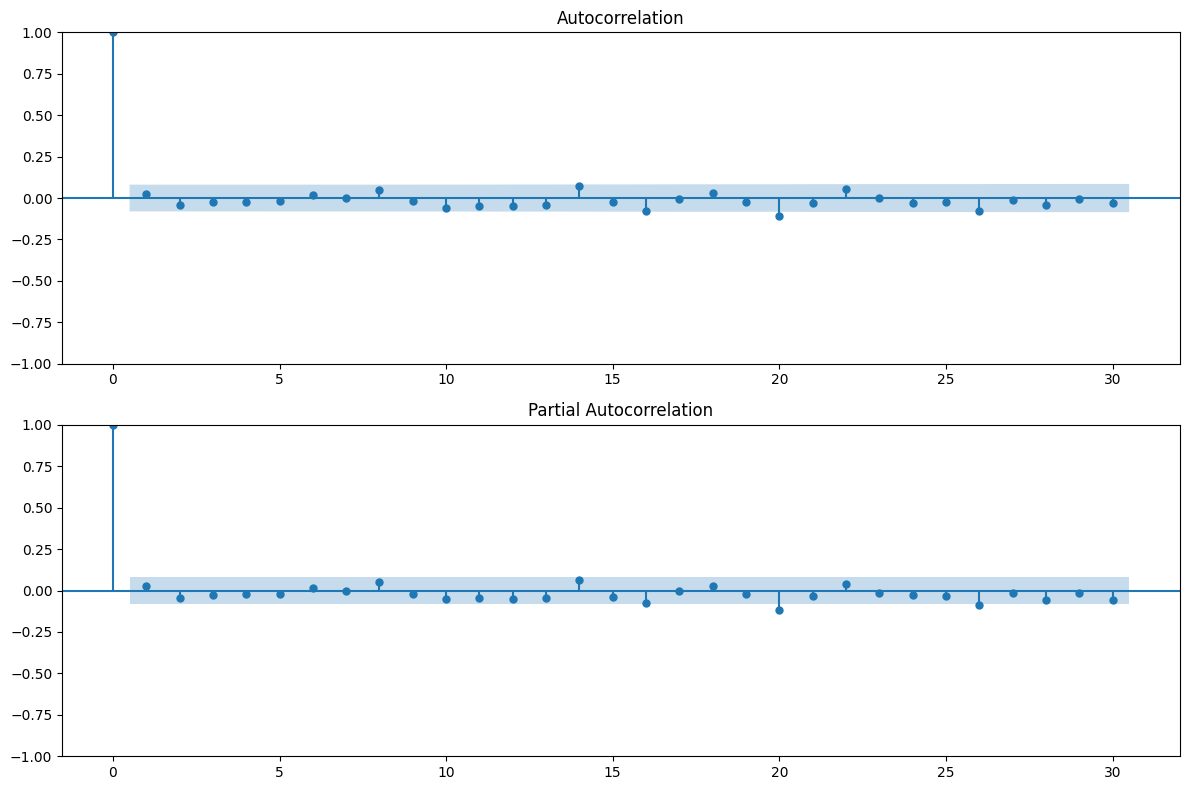

In [95]:
# ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(full_residuals, lags=30, alpha=0.05, ax=ax1)
plot_pacf(full_residuals, lags=30, alpha=0.05, ax=ax2)
plt.tight_layout()
plt.show()

The ACF and PACF plots showed values close to zero, indicating that the SARIMA model successfully captured all underlying patterns.

In [96]:
# Ljung-Box Test (for autocorrelation)
lb_test = acorr_ljungbox(full_residuals, lags=30, return_df=True)
print("Ljung-Box Test (Full Dataset):")
print(lb_test)

Ljung-Box Test (Full Dataset):
      lb_stat  lb_pvalue
1    0.433790   0.510135
2    1.576375   0.454668
3    1.993415   0.573775
4    2.260693   0.687934
5    2.439059   0.785644
6    2.669726   0.849010
7    2.670305   0.913737
8    4.267350   0.832233
9    4.432789   0.880693
10   6.401047   0.780519
11   7.900211   0.722214
12   9.232712   0.682936
13  10.245908   0.673713
14  13.223328   0.509019
15  13.638206   0.553126
16  17.205686   0.372410
17  17.243959   0.437960
18  17.769276   0.470947
19  18.062615   0.518259
20  25.203736   0.193748
21  25.832192   0.212920
22  27.867005   0.180131
23  27.868100   0.220811
24  28.362683   0.245040
25  28.715794   0.275971
26  32.286209   0.183827
27  32.386081   0.218087
28  33.367303   0.222483
29  33.376529   0.262813
30  33.988356   0.281299


The Ljung-Box test showed a p-value greater than 0.05, further confirming that the model effectively captured all relevant patterns.

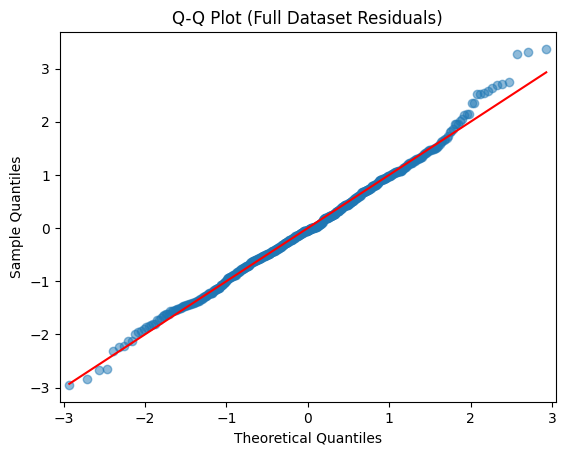

In [97]:
# Normality Check
qqplot(full_residuals, line='s', fit=True, alpha=0.5)
plt.title('Q-Q Plot (Full Dataset Residuals)')
plt.show()

The normality of the residuals, as indicated by the Q-Q plots, showed that the points closely overlapped the red straight line, suggesting that the residuals followed a normal distribution and thus satisfied the SARIMA model assumptions.

In [98]:
# ADF Test on Residuals
adf_test(full_residuals, title='Model Residuals (Full Dataset)')


ADF Test: Model Residuals (Full Dataset)
ADF Statistic: -23.53381662257308
p-value: 0.0
Critical Values:
   1%: -3.4415011513018263
   5%: -2.8664595311890215
   10%: -2.569389981494346
Result: Stationary


After differencing with order d=1, the residuals has a p-value approaching zero, indicating that the model is stationary.

## Model Evaluation

In [99]:
# Get fitted values (transformed scale, after burn-in)
full_preds_transformed = sarima_full_results.fittedvalues.iloc[burn_in:]

# Confidence intervals (transformed scale, after burn-in)
full_ci_transformed = sarima_full_results.get_prediction(
    start=burn_in,
    end=len(daily_revenue) - 1
).conf_int()

In [100]:
# Inverse transform to original scale
full_preds = pt_full.inverse_transform(
    full_preds_transformed.values.reshape(-1, 1)
).flatten().clip(min=0)

# Inverse transform to original scale (confidence intervals)
full_ci_lower = pt_full.inverse_transform(
    full_ci_transformed.iloc[:, 0].values.reshape(-1, 1)
).flatten().clip(min=0)
full_ci_upper = pt_full.inverse_transform(
    full_ci_transformed.iloc[:, 1].values.reshape(-1, 1)
).flatten().clip(min=0)

In [101]:
# Align actual values
full_actuals = daily_revenue['y_original'].iloc[burn_in:burn_in + len(full_preds)]

In [102]:
# Calculate metrics
full_metrics = calculate_metrics(full_actuals, full_preds, 'SARIMA (Full Dataset)')
print(pd.DataFrame([full_metrics]).to_markdown(tablefmt="grid", index=False))

+-----------------------+-------------+---------+---------+---------+---------+
| Model                 |         MSE |    RMSE |     MAE |    MAPE |   SMAPE |
+=======================+=============+=========+=========+=========+=========+
| SARIMA (Full Dataset) | 2.86807e+07 | 5355.44 | 4100.78 | 19.1826 | 18.0968 |
+-----------------------+-------------+---------+---------+---------+---------+


In [103]:
# --- Calculate new metrics for full dataset ---
# PIC & PIW
within_ci_full = (full_actuals >= full_ci_lower) & (full_actuals <= full_ci_upper)
pic_full = np.mean(within_ci_full) * 100
piw_full = np.mean(full_ci_upper - full_ci_lower)

# MDA
prev_actual = daily_revenue['y_original'].iloc[burn_in - 1] if burn_in > 0 else full_actuals.iloc[0]
mda_correct_full = 0
for i in range(len(full_actuals)):
    current_actual = full_actuals.iloc[i]
    current_pred = full_preds[i]
    actual_dir = current_actual > prev_actual
    forecast_dir = current_pred > prev_actual
    if actual_dir == forecast_dir:
        mda_correct_full += 1
    prev_actual = current_actual
mda_full = (mda_correct_full / len(full_actuals)) * 100

# Forecast Bias
forecast_bias_full = np.mean(full_actuals - full_preds)

# Update metrics dictionary
full_metrics.update({
    'PIW': piw_full,
    'PIC': pic_full,
    'MDA': mda_full,
    'Forecast Bias': forecast_bias_full
})

In [104]:
# Compare with test metrics
print("=== Train/Test/Full Metrics Comparison ===")
print(pd.DataFrame([sarima_train_metrics, sarima_test_metrics, full_metrics]).to_markdown(tablefmt="grid", index=False))

=== Train/Test/Full Metrics Comparison ===
+--------------------------------------+-------------+---------+---------+---------+---------+---------+---------+---------+-----------------+
| Model                                |         MSE |    RMSE |     MAE |    MAPE |   SMAPE |     PIW |     PIC |     MDA |   Forecast Bias |
+======================================+=============+=========+=========+=========+=========+=========+=========+=========+=================+
| SARIMA (Train)                       | 2.84384e+07 | 5332.76 | 4070.63 | 19.984  | 18.5525 | 20225.5 | 95.1786 | 76.4286 |        -42.7769 |
+--------------------------------------+-------------+---------+---------+---------+---------+---------+---------+---------+-----------------+
| SARIMA (Test - 1-Day Rolling Window) | 2.97909e+07 | 5458.1  | 4564.77 | 12.5454 | 11.7058 | 26066.2 | 96.6667 | 66.6667 |      -1454.12   |
+--------------------------------------+-------------+---------+---------+---------+---------+-----

As we can see here, in the comparison of the model descriptions, the RMSE of the SARIMA (Full Dataset) model lies between the SARIMA (Train) and SARIMA (Test - 1-Day Rolling Window) results. This effect occurs because the full dataset forecast evaluates all historical dates, not just the test set (the last 30 days).

In [105]:
print(sarima_full_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     y_transformed   No. Observations:                  600
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -257.826
Date:                           Sat, 26 Apr 2025   AIC                            527.652
Time:                                   15:31:32   BIC                            554.024
Sample:                                        0   HQIC                           537.919
                                           - 600                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
is_black_friday          1.5988      0.361      4.431      0.000       0.892       2.306
is_black_frid

Like the model summary for the test evaluation forecast, the model summary on the full dataset shows that the model has the best parameters (1, 1, 1) × (1, 0, 1, 7) (p, d, q) × (P, D, Q, S). All the features, such as is_black_friday and is_black_friday_peak, show significant effects, as indicated by very low p-values (P > |z|). The probability from the Ljung-Box test being greater than 0.05 indicates that the residuals are white noise.

## Model Visualization

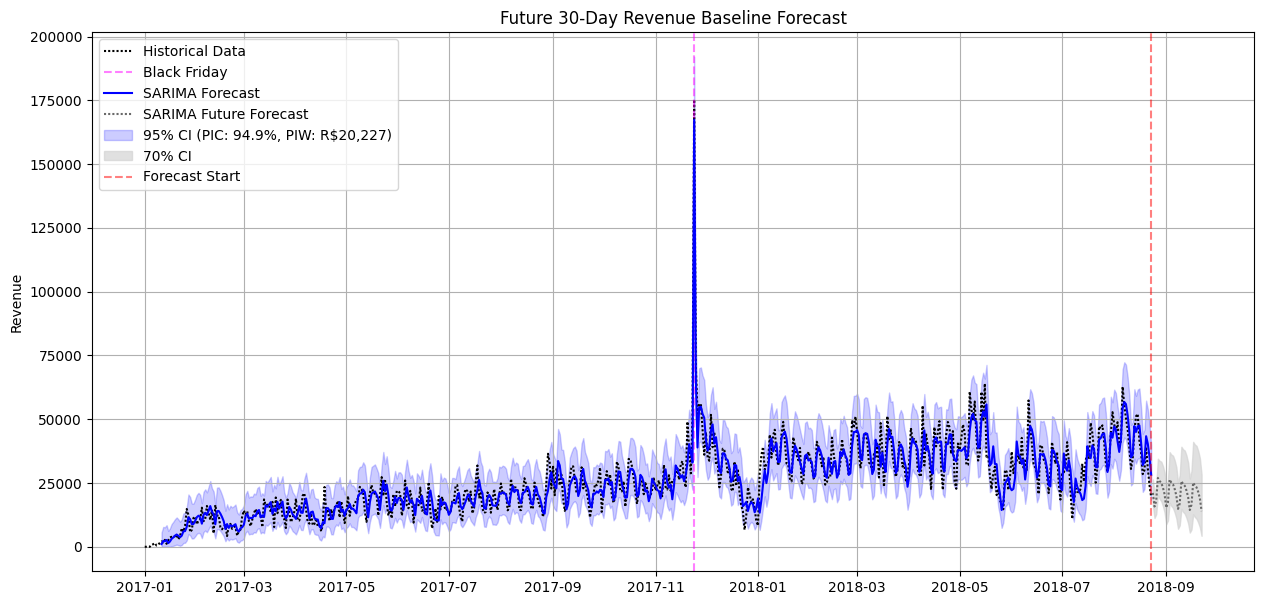

In [106]:
plt.figure(figsize=(15, 7))

# Historical Data
plt.plot(daily_revenue['ds'], daily_revenue['y_original'], label='Historical Data', linestyle=(0, (1, 1)), color='black')

# Highlight Black Friday dates with only one legend entry
black_friday_label_added = False
for bf_date in black_friday_dates['ds']:
    if bf_date in train['ds'].values:
        plt.axvline(
            x=bf_date,
            color='magenta',
            linestyle='--',
            alpha=0.5,
            label='Black Friday' if not black_friday_label_added else ""
        )
        black_friday_label_added = True

# Model Fit (after burn-in)
plt.plot(daily_revenue['ds'].iloc[burn_in:], full_preds, label='SARIMA Forecast', color='blue')

# Future Forecasts
plt.plot(sarima_future_forecast['ds'], sarima_future_forecast['yhat'], label='SARIMA Future Forecast', color='dimgray', linestyle=(0, (1, 1)))

# Add shaded confidence intervals to the full dataset plot
plt.fill_between(daily_revenue['ds'].iloc[burn_in:], full_ci_lower, full_ci_upper,
    color='blue', alpha=0.2,label=f'95% CI (PIC: {pic_full:.1f}%, PIW: R${piw_full:,.0f})')

# Confidence Intervals
plt.fill_between(sarima_future_forecast['ds'],
                 sarima_future_forecast['yhat_lower'],
                 sarima_future_forecast['yhat_upper'],
                 color='lightgray', alpha=0.7, label='70% CI')

# Annotations
plt.axvline(x=daily_revenue['ds'].max(), color='red',  linestyle='--', alpha=0.5, label='Forecast Start')
plt.title('Future 30-Day Revenue Baseline Forecast')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

The graph above shows the forecast of the next 30 days of revenue beyond the dataset, based on the full dataset.

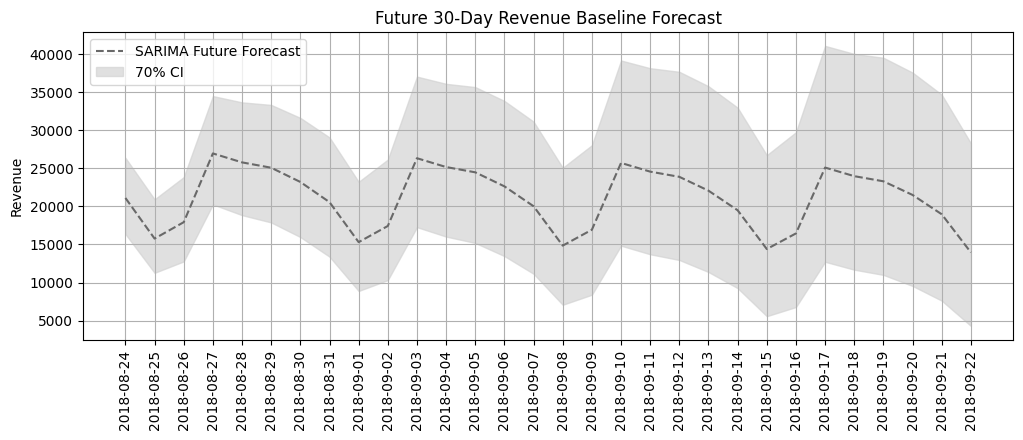

In [107]:
plt.figure(figsize=(12, 4))

# Future Forecasts
plt.plot(sarima_future_forecast['ds'], sarima_future_forecast['yhat'], label='SARIMA Future Forecast', color='dimgray', linestyle='--')

# Confidence Intervals
plt.fill_between(sarima_future_forecast['ds'],
                 sarima_future_forecast['yhat_lower'],
                 sarima_future_forecast['yhat_upper'],
                 color='lightgray', alpha=0.7, label='70% CI')

# Formatting
plt.title('Future 30-Day Revenue Baseline Forecast')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(sarima_future_forecast['ds'], rotation=90)
plt.grid(True)
plt.show()

In [108]:
print("="*50)
print("SARIMA Future Baseline Forecast (next 30 days):")
print("="*50)
print(pd.DataFrame({
    'date': future_dates,
    'forecast': future_pred,
    'lower_ci': sarima_beyond_ci_lower,
    'upper_ci': sarima_beyond_ci_upper
}))

SARIMA Future Baseline Forecast (next 30 days):
         date      forecast      lower_ci      upper_ci
0  2018-08-24  21119.691785  16373.337270  26397.895551
1  2018-08-25  15776.424418  11273.260833  20942.531801
2  2018-08-26  17934.928041  12775.491483  23860.875476
3  2018-08-27  26979.608710  20275.756287  34524.894241
4  2018-08-28  25802.178250  18862.099921  33696.058877
5  2018-08-29  25098.111489  17900.945312  33360.584778
6  2018-08-30  23225.691926  15980.636171  31654.566476
7  2018-08-31  20572.335064  13398.976308  29085.227304
8  2018-09-01  15310.338681   8885.705943  23245.929855
9  2018-09-02  17434.948615  10317.674803  26168.293969
10 2018-09-03  26351.259988  17283.803243  37084.980541
11 2018-09-04  25189.568138  16040.657044  36134.143827
12 2018-09-05  24495.030487  15206.348076  35706.472293
13 2018-09-06  22648.416902  13476.105696  33882.576875
14 2018-09-07  20032.925930  11148.306911  31162.065760
15 2018-09-08  14851.795662   7071.519290  25093.600483
